In [49]:
#%pip install spacy

In [1]:
import requests
import seaborn as sns
import pandas as pd
import time
import numpy as np
import pickle
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, RocCurveDisplay
from nltk import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import spacy
import time
import warnings
import matplotlib.pyplot as plt

In [2]:
with open('../data/pickledcooking.pkl','rb') as x:
    df_cook = pickle.load(x)

In [3]:
with open('../data/pickledbeginners.pkl','rb') as x:
    df_cforb = pickle.load(x)

In [4]:
df_cook['sub'] = 'r/Cooking'

df_cforb['sub'] = 'r/Cookingforbeginners'

In [5]:
textdata = pd.concat([df_cook[['title','sub']],df_cforb[['title','sub']]])

In [6]:
X = textdata['title']
y = textdata['sub']

In [7]:
X.value_counts(normalize=True,ascending=False).head()

Culinary Arts School Delhi - Diploma Courses in Culinary Arts    0.000415
YWB mez-Scotty Pippin                                            0.000208
A dumb question about leaving dough out                          0.000161
Help!                                                            0.000138
Where do I start?                                                0.000138
Name: title, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=39,stratify=y)

In [9]:
pipe1 = Pipeline([
    ('cv',CountVectorizer(strip_accents='unicode',ngram_range=(1,1),max_features=None)),
    ('logreg',LogisticRegression(penalty='l2',max_iter=1000))#just calling some of these so you keep them in mind
])

In [10]:
pipe1.fit(X_train,y_train)
pipe1.score(X_train,y_train), pipe1.score(X_test,y_test)

(0.7621186023622047, 0.6118287506920096)

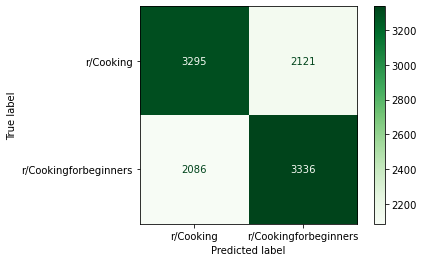

In [11]:
ConfusionMatrixDisplay.from_estimator(pipe1,X_test,y_test,cmap='Greens')

In [41]:
pipe3 = Pipeline([
    ('cv',CountVectorizer(strip_accents='ascii',max_features=1000,max_df=0.8)),
    ('abc',AdaBoostClassifier(n_estimators=3000,random_state=815))
])

In [32]:
pipe3.fit(X_train,y_train)
pipe3.score(X_train,y_train), pipe3.score(X_test,y_test)

(0.6574495570866141, 0.6121978224764717)

In [33]:
cv = CountVectorizer(strip_accents='unicode',ngram_range=(1,1),max_features=None)
X_enc = cv.fit_transform(X_train,y_train)

In [34]:
X_enc

<32512x15752 sparse matrix of type '<class 'numpy.int64'>'
	with 272165 stored elements in Compressed Sparse Row format>

In [35]:
logreg = LogisticRegression(max_iter=10_000)
logreg.fit(X_enc,y_train)

LogisticRegression(max_iter=10000)

In [36]:
abc = AdaBoostClassifier(n_estimators=500,random_state=815)
abc.fit(X_enc,y_train)

AdaBoostClassifier(n_estimators=500, random_state=815)

In [37]:
abc.score(X_enc,y_train)

0.6503752460629921

In [38]:
pd.DataFrame(abc.feature_importances_,index=cv.get_feature_names_out(),columns=['ft_imp']).sort_values(by='ft_imp',ascending=False).head(25)

,ft_imp
this,0.004
how,0.004
of,0.004
what,0.004
cookies,0.004
frozen,0.004
paratha,0.004
your,0.004
and,0.004
healthy,0.004


In [39]:
tfidf = TfidfVectorizer(strip_accents='ascii',stop_words='english',ngram_range=(1,2),min_df=5,max_df=0.8,norm='l1')
tfidf.fit(X_train,y_train)
X_enctoo = tfidf.transform(X_train)

In [40]:
abctoo = AdaBoostClassifier(n_estimators=500,random_state=815)
abctoo.fit(X_enctoo,y_train)


AdaBoostClassifier(n_estimators=500, random_state=815)

In [41]:
pd.DataFrame(abctoo.feature_importances_,index=tfidf.get_feature_names_out(),columns=['ft_imp']).sort_values(by='ft_imp',ascending=False).head(25)

,ft_imp
looking,0.004
scratch,0.004
amp,0.004
learn,0.004
street,0.004
cook,0.004
sweet potatoes,0.004
frozen,0.004
thing,0.004
cooking,0.004


In [42]:
abctoo.score(tfidf.transform(X_test),y_test)

0.5988189702897213

In [12]:
nlp = spacy.load("en_core_web_sm")

'TRF' seems to work better, but it takes at least 10 times as long, we should try something simpler first, just for testing purposes

In [13]:
doc = nlp('I am becoming a better human being')

In [14]:
start_time = time.time()
X_trlemma = []
for i in range(len(X_train)):
    X_trlemma.append(' '.join([w.lemma_ for w in nlp(X_train.iloc[i])]))
end_time = time.time()
end_time-start_time

213.42405319213867

In [15]:
' '.join([w.lemma_ for w in nlp(X_train.iloc[1])])

'what be your favourite kind of cheese , and your favourite way to use it ?'

In [16]:
X_train.iloc[0]

'Easiest Shakshouka ever! Even I can make it!'

In [17]:
pipe4= Pipeline([
    ('cv',CountVectorizer(strip_accents='unicode',stop_words='english')),
    ('rfc', RandomForestClassifier(n_estimators=200,min_samples_split=3,n_jobs=-1,random_state=39,criterion='entropy'))
])

In [18]:
X_telemma = []
for i in range(len(X_test)):
    X_telemma.append(' '.join([w.lemma_ for w in nlp(X_test.iloc[i])]))
    
X_telemma = pd.Series(X_telemma)

In [19]:
X_trlemma = pd.Series(X_trlemma)

In [20]:
start_time=time.time()
pipe4.fit(X_trlemma,y_train)
end_time=time.time()
pipe4.score(X_trlemma,y_train),pipe4.score(X_telemma,y_test), end_time-start_time


(0.9863742618110236, 0.5961431998523713, 59.35916543006897)

In [21]:
pipe4.fit(X_train,y_train)
pipe4.score(X_train,y_train), pipe4.score(X_test,y_test)

(0.9885888287401575, 0.5967890754751799)

This lemma seems at best comparable to the standard text, which makes it dubious what gain there would be from continuing testing the lemma in particular. Maybe there would be more gain from the more complicated one, but given the time commitment and whkat we've seen from this one, it's not worth pursuing

In [38]:
paramlist4 = {
    'cv__stop_words' : ['english',None],
    'cv__ngram_range' : [(1,1),(1,2),(2,2)],
    'cv__max_features' : [1000,1500,750],
    'cv__max_df' : [1.0,0.8,0.6],
    'rfc__n_estimators' :[100,200,50,30],
    'rfc__min_samples_split' : [2,3,4,5]
}

In [39]:
rsc4 = RandomizedSearchCV(pipe4,param_distributions=paramlist4,n_jobs=-1,n_iter=20)

In [40]:
rsc4.fit(X_train,y_train),
rsc4.score(X_train,y_train),rsc4.score(X_test,y_test)

(0.9604146161417323, 0.613858645506551)

In [41]:
rsc4.best_params_

{'rfc__n_estimators': 100,
 'rfc__min_samples_split': 5,
 'cv__stop_words': None,
 'cv__ngram_range': (1, 1),
 'cv__max_features': 1000,
 'cv__max_df': 1.0}

In [44]:
pd.DataFrame(rsc4.cv_results_).sort_values(by='mean_test_score',ascending=False).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__n_estimators,param_rfc__min_samples_split,param_cv__stop_words,param_cv__ngram_range,param_cv__max_features,param_cv__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,40.309121,0.609506,2.312618,0.299428,100,5,None,"(1, 1)",1000,1.0,"{'rfc__n_estimators': 100, 'rfc__min_samples_s...",0.606182,0.614486,0.609659,0.617195,0.605352,0.610575,0.004616,1
13,43.198801,0.746960,2.267895,0.601610,100,4,None,"(1, 1)",1500,0.6,"{'rfc__n_estimators': 100, 'rfc__min_samples_s...",0.608335,0.608796,0.610581,0.617810,0.603660,0.609836,0.004596,2
5,89.052540,4.167824,3.193461,0.589482,200,5,None,"(1, 2)",1500,1.0,"{'rfc__n_estimators': 200, 'rfc__min_samples_s...",0.604336,0.609103,0.608121,0.610120,0.602891,0.606914,0.002805,3
19,20.874384,1.851434,1.695865,0.548559,50,5,None,"(1, 1)",1000,1.0,"{'rfc__n_estimators': 50, 'rfc__min_samples_sp...",0.604336,0.607873,0.609351,0.611812,0.599508,0.606576,0.004284,4


In [45]:
paramlist4_1 = {
    'cv__max_df' : [0.5,0.6,1.0],
    'cv__max_features' : [1000,1500],
    'cv__stop_words' : [None],
    'cv__ngram_range' : [(1,1)],
    'rfc__n_estimators' : [100,125],
    'rfc__min_samples_split' :[4,5,6,7]
}

rsc4_1 = RandomizedSearchCV(pipe4,param_distributions=paramlist4_1,n_jobs=-1,n_iter=20)

In [46]:
rsc4_1.fit(X_train,y_train)
rsc4_1.score(X_train,y_train),rsc4_1.score(X_test,y_test)

(0.9677657480314961, 0.6169034877283631)

In [47]:
rsc4_1.best_params_

{'rfc__n_estimators': 100,
 'rfc__min_samples_split': 5,
 'cv__stop_words': None,
 'cv__ngram_range': (1, 1),
 'cv__max_features': 1500,
 'cv__max_df': 0.5}

In [48]:
pd.DataFrame(rsc4_1.cv_results_).sort_values(by='mean_test_score',ascending=False).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__n_estimators,param_rfc__min_samples_split,param_cv__stop_words,param_cv__ngram_range,param_cv__max_features,param_cv__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,41.078845,0.597046,2.317602,0.378870,100,5,None,"(1, 1)",1500,0.5,"{'rfc__n_estimators': 100, 'rfc__min_samples_s...",0.610641,0.609719,0.617502,0.618886,0.607659,0.612882,0.004466,1
7,36.687817,0.947188,2.354703,0.361524,100,7,None,"(1, 1)",1500,0.5,"{'rfc__n_estimators': 100, 'rfc__min_samples_s...",0.606643,0.613409,0.613965,0.619963,0.608121,0.612420,0.004735,2
15,36.341716,0.973371,2.558359,0.241392,100,7,None,"(1, 1)",1500,1.0,"{'rfc__n_estimators': 100, 'rfc__min_samples_s...",0.606643,0.613409,0.613965,0.619963,0.608121,0.612420,0.004735,2
8,36.452929,0.345831,2.553274,0.541924,100,7,None,"(1, 1)",1500,0.6,"{'rfc__n_estimators': 100, 'rfc__min_samples_s...",0.606643,0.613409,0.613965,0.619963,0.608121,0.612420,0.004735,2


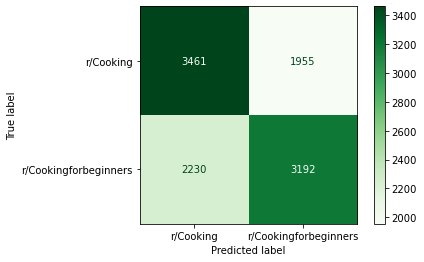

In [54]:
ConfusionMatrixDisplay.from_estimator(rsc4,X_test,y_test,cmap='Greens');

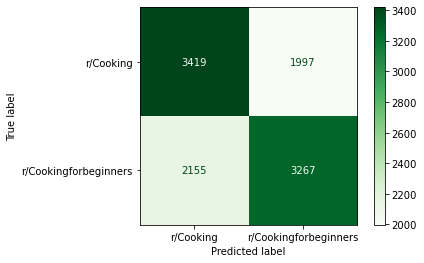

In [55]:
ConfusionMatrixDisplay.from_estimator(rsc4_1,X_test,y_test,cmap='Greens')

In [22]:
pipe5 = Pipeline([
    ('cv',CountVectorizer(strip_accents='unicode',ngram_range=(1,1),max_features=1250,max_df=0.5)),
    ('mnb',MultinomialNB())
])

In [23]:
start_time=time.time()
pipe5.fit(X_train,y_train)
end_time=time.time()
pipe5.score(X_train,y_train),pipe5.score(X_test,y_test),end_time-start_time

(0.6321358267716536, 0.6056467983022698, 0.5302422046661377)

That's shockingly fast and in the range of the other scores, to the point that you can run lots of grid-searchs without worry

In [24]:
paramlist5 = {
    'cv__stop_words' : ['english',None],
    'cv__ngram_range' : [(1,1),(1,2),(2,2)],
    'cv__max_features' : [1000,1500,750,1250,None],
    'cv__max_df' : [1.0,0.8,0.6],
    'mnb__alpha' : [0,1,0.5,5]
}

In [25]:
rsc5 = RandomizedSearchCV(pipe5,param_distributions=paramlist5,n_jobs=-1,random_state=815)

In [26]:
start_time=time.time()
rsc5.fit(X_train,y_train)
end_time=time.time()
rsc5.score(X_train,y_train),rsc5.score(X_test,y_test),end_time-start_time

(0.8964997539370079, 0.6259457464476841, 25.087990522384644)

27 seconds! We can go systematically over all 270 in 12 minutes. So let's

In [38]:
gs5 = GridSearchCV(pipe5,param_grid=paramlist5,n_jobs=-1)

In [39]:
start_time=time.time()
gs5.fit(X_train,y_train)
end_time=time.time()
gs5.score(X_train,y_train),gs5.score(X_test,y_test),end_time-start_time

(0.8061023622047244, 0.6271452297471858, 709.4733910560608)

In [65]:
gs5.best_params_

{'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': None,
 'mnb__alpha': 5}

In [66]:
pd.DataFrame(gs5.cv_results_).sort_values(by='mean_test_score',ascending=False).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cv__max_df,param_cv__max_features,param_cv__ngram_range,param_cv__stop_words,param_mnb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
351,1.987242,0.031636,0.347448,0.018305,0.6,None,"(1, 2)",None,5,"{'cv__max_df': 0.6, 'cv__max_features': None, ...",0.619099,0.624789,0.622270,0.627038,0.627653,0.624170,0.003164,1
231,2.196498,0.057474,0.380695,0.041701,0.8,None,"(1, 2)",None,5,"{'cv__max_df': 0.8, 'cv__max_features': None, ...",0.619099,0.624789,0.622270,0.627038,0.627653,0.624170,0.003164,1
111,1.900121,0.025742,0.374215,0.074642,1.0,None,"(1, 2)",None,5,"{'cv__max_df': 1.0, 'cv__max_features': None, ...",0.619099,0.624789,0.622270,0.627038,0.627653,0.624170,0.003164,1
229,2.077431,0.048492,0.390819,0.066754,0.8,None,"(1, 2)",None,1,"{'cv__max_df': 0.8, 'cv__max_features': None, ...",0.616792,0.623866,0.615349,0.622424,0.624423,0.620571,0.003760,4


So we got a slight improvement in our score, and the best ones were all the same except for max_df- and even that didn't actually change the score. Might be worth some time to find where the model messed up and furthermore, test along the alpha, see if it matters

In [27]:
rsc5alt = RandomizedSearchCV(pipe5,param_distributions=paramlist5,n_jobs=-1,random_state=815)
rsc5alt.fit(X_trlemma,y_train)
rsc5alt.score(X_trlemma,y_train), rsc5alt.score(X_telemma,y_test)

(0.8881028543307087, 0.6290828566156117)

But just as a test, I tested how lemmitization would work- and it marginally increased it even past the past gridsearch! We might as well go through the full gridsearch

In [71]:
gs5alt = GridSearchCV(pipe5,param_grid=paramlist5,n_jobs=-1)


In [72]:
start_time=time.time()
gs5alt.fit(X_trlemma,y_train)
end_time=time.time()
gs5alt.score(X_trlemma,y_train),gs5alt.score(X_telemma,y_test),end_time-start_time

(0.7982898622047244, 0.6247462631481823, 782.0593791007996)

That's slightly worse on train *and* test score...

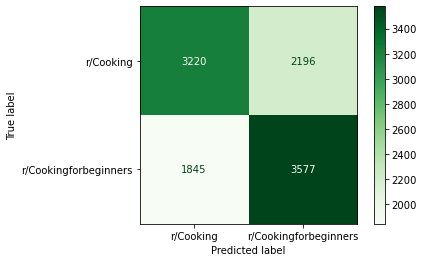

In [70]:
ConfusionMatrixDisplay.from_estimator(gs5,X_test,y_test,cmap='Greens')

In [75]:
rsc5alt.best_params_, gs5alt.best_params_

({'mnb__alpha': 1,
  'cv__stop_words': None,
  'cv__ngram_range': (1, 2),
  'cv__max_features': None,
  'cv__max_df': 0.8},
 {'cv__max_df': 1.0,
  'cv__max_features': None,
  'cv__ngram_range': (1, 2),
  'cv__stop_words': None,
  'mnb__alpha': 5})

In [76]:
pd.DataFrame(rsc5alt.cv_results_).sort_values(by='mean_test_score',ascending=False).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__alpha,param_cv__stop_words,param_cv__ngram_range,param_cv__max_features,param_cv__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,1.801799,0.182440,0.286472,0.058188,1,None,"(1, 2)",None,0.8,"{'mnb__alpha': 1, 'cv__stop_words': None, 'cv_...",0.611410,0.629709,0.617195,0.629191,0.631498,0.623801,0.008005,1
8,0.986287,0.197822,0.202252,0.005135,5,english,"(1, 1)",None,0.6,"{'mnb__alpha': 5, 'cv__stop_words': 'english',...",0.610026,0.608335,0.600431,0.615042,0.606429,0.608052,0.004766,2
4,1.980813,0.035081,0.340108,0.019503,1,None,"(1, 2)",1500,1.0,"{'mnb__alpha': 1, 'cv__stop_words': None, 'cv_...",0.602030,0.612948,0.599354,0.610735,0.608582,0.606730,0.005189,3
1,0.909003,0.017574,0.202368,0.009502,0.5,english,"(1, 1)",None,0.6,"{'mnb__alpha': 0.5, 'cv__stop_words': 'english...",0.606643,0.604798,0.603507,0.609505,0.606275,0.606145,0.002016,4


In [77]:
pd.DataFrame(gs5alt.cv_results_).sort_values(by='mean_test_score',ascending=False).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cv__max_df,param_cv__max_features,param_cv__ngram_range,param_cv__stop_words,param_mnb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
231,1.963355,0.024017,0.347187,0.012220,0.8,None,"(1, 2)",None,5,"{'cv__max_df': 0.8, 'cv__max_features': None, ...",0.61587,0.628325,0.616733,0.629499,0.631037,0.624293,0.006587,1
351,1.825305,0.009600,0.336915,0.018133,0.6,None,"(1, 2)",None,5,"{'cv__max_df': 0.6, 'cv__max_features': None, ...",0.61587,0.628325,0.616733,0.629499,0.631037,0.624293,0.006587,1
111,2.110857,0.190354,0.521728,0.095658,1.0,None,"(1, 2)",None,5,"{'cv__max_df': 1.0, 'cv__max_features': None, ...",0.61587,0.628325,0.616733,0.629499,0.631037,0.624293,0.006587,1
109,1.984388,0.033456,0.340205,0.012429,1.0,None,"(1, 2)",None,1,"{'cv__max_df': 1.0, 'cv__max_features': None, ...",0.61141,0.629709,0.617195,0.629191,0.631498,0.623801,0.008005,4


Let's see if by changing the MNB alpha, we can improve the original gridsearch past the lemmatized randomsearch one

In [81]:
paramlist5_1 = {
    'cv__max_features' : [None],
    'cv__max_df' : [0.6,0.8,1.0],
    'cv__ngram_range' : [(1,2)],
    'mnb__alpha' : [1,4,5,6,7,10]
}

In [83]:
gs5_1 = GridSearchCV(pipe5,param_grid=paramlist5_1,n_jobs=-1)

In [84]:
start_time=time.time()
gs5_1.fit(X_train,y_train)
end_time=time.time()
gs5_1.score(X_train,y_train),gs5_1.score(X_test,y_test),end_time-start_time

(0.8061023622047244, 0.6271452297471858, 52.08309197425842)

In [85]:
gs5.best_params_

{'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': None,
 'mnb__alpha': 5}

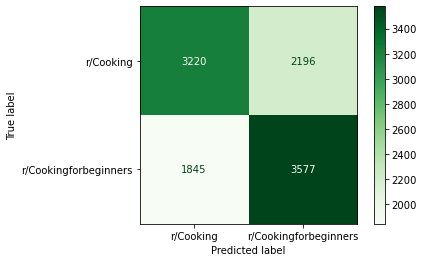

In [87]:
ConfusionMatrixDisplay.from_estimator(gs5,X_test,y_test,cmap='Greens')

So far, it's only been the case in the self-text that we had odd patterns where the model was better at predicting one class over the other despite having an almost perfectly even split-set. We could try a extratreesclassifier, which had that property in self-text. Along with that we could try a Gaussian Naive-Bayes classifier with Tfidf- and even a voting classifier if we can figure out some kind of variance we can exploit. But after that, we should probably proceed into feature importance, odd passages that stand out and had difficulty being fit, etc

In [28]:
pipe6 = Pipeline([
    ('cv', CountVectorizer()),
    ('etc', ExtraTreesClassifier(n_jobs=-1,random_state=815))
])

In [29]:
paramlist6 = {
    'cv__max_df' : [0.8,0.9,1],
    'cv__ngram_range' : [(1,1),(1,2),(2,2)],
    'cv__strip_accents' : ['unicode'],
    'cv__max_features' : [None,1000,750],
    'etc__min_samples_split' : [2,3,4,5,6,7],
    'etc__criterion' : ['gini','entropy'],
    'etc__n_estimators' : [100,50,200,75]
}

In [96]:
rsc6 = RandomizedSearchCV(pipe6, param_distributions=paramlist6,n_iter=20,n_jobs=-1)

In [99]:
rsc6.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                             ('etc',
                                              ExtraTreesClassifier(n_jobs=-1,
                                                                   random_state=815))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'cv__max_df': [0.8, 0.9, 1],
                                        'cv__max_features': [None, 1000, 750],
                                        'cv__ngram_range': [(1, 1), (1, 2),
                                                            (2, 2)],
                                        'cv__strip_accents': ['unicode'],
                                        'etc__criterion': ['gini', 'entropy'],
                                        'etc__min_samples_split': [2, 3, 4, 5,
                                                                   6, 7],
                                        'etc__n_estimators': [100, 5

In [100]:
rsc6.score(X_train,y_train), rsc6.score(X_test,y_test)

(0.9933255413385826, 0.6225318324414099)

In [101]:
with open('C:/Users/Karthik/Documents/DSIProj3largedata/extrapickledtreesttitle.pkl','wb') as pickle_out:
    pickle.dump(rsc6,pickle_out)

In [32]:
with open('C:/Users/Karthik/Documents/DSIProj3largedata/extrapickledtreesttitle.pkl','rb') as x:
    rsc6 = pickle.load(x)

In [33]:
rsc6.best_params_

{'etc__n_estimators': 200,
 'etc__min_samples_split': 6,
 'etc__criterion': 'entropy',
 'cv__strip_accents': 'unicode',
 'cv__ngram_range': (1, 2),
 'cv__max_features': None,
 'cv__max_df': 0.8}

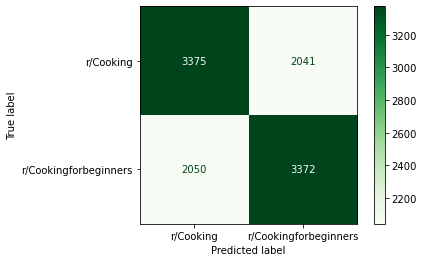

In [106]:
ConfusionMatrixDisplay.from_estimator(rsc6,X_test,y_test,cmap='Greens');

In [127]:
pipe7 = Pipeline([
    ('tf',TfidfVectorizer(strip_accents='unicode',max_features=1000)),
    ('ft',FunctionTransformer(lambda x: x.todense(),accept_sparse=True)),
    ('gnb',GaussianNB())
])

https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required taken from help on this page

In [133]:
warnings.filterwarnings('ignore')

In [134]:
start_time=time.time()
pipe7.fit(X_train,y_train)
end_time=time.time()
pipe7.score(X_train,y_train),pipe7.score(X_test,y_test),end_time-start_time


(0.6200787401574803, 0.5805499169588485, 1.1520576477050781)

In [136]:
paramlist7 = {
    'tf__max_features' : [1000,1250,750],
    'tf__stop_words' : ['english',None],
    'tf__ngram_range' : [(1,1),(1,2),(1,3)],
    'tf__max_df' : [1,0.9,0.8],
    'tf__norm' : ['l1','l2'],
    'gnb__var_smoothing' : [1e-9,1e-8,0,2e-9]
}

In [137]:
gs7 = GridSearchCV(pipe7,param_grid=paramlist7,n_jobs=-1)

In [138]:
start_time=time.time()
gs7.fit(X_train,y_train)
end_time=time.time()
gs7.score(X_train,y_train),gs7.score(X_test,y_test),end_time-start_time

(0.6327202263779528, 0.5967890754751799, 1779.7616064548492)

In [139]:
gs7.best_params_

{'gnb__var_smoothing': 1e-08,
 'tf__max_df': 0.9,
 'tf__max_features': 1250,
 'tf__ngram_range': (1, 2),
 'tf__norm': 'l2',
 'tf__stop_words': None}

In [141]:
rsc7alt = RandomizedSearchCV(pipe7,param_distributions=paramlist7,n_jobs=-1)

In [143]:
rsc7alt.fit(X_trlemma,y_train)
rsc7alt.score(X_trlemma,y_train),rsc7alt.score(X_telemma,y_test)

(0.6278297244094488, 0.585440118102971)

All of these Gaussian Naive Bayes have been bad. Let's collect all the classifiers we've looked at, see if any stand out, and then see if we can't mash them together

In [145]:
pipe1.score(X_test,y_test),rsc4.score(X_test,y_test),rsc4_1.score(X_test,y_test),rsc5.score(X_test,y_test)

(0.6118287506920096, 0.613858645506551, 0.6169034877283631, 0.6259457464476841)

In [157]:
rsc5alt.score(X_telemma,y_test),rsc6.score(X_test,y_test), rsc7alt.score(X_telemma,y_test)

(0.6290828566156117, 0.6225318324414099, 0.585440118102971)

In [155]:
gs5.score(X_test,y_test), gs5_1.score(X_test,y_test), gs5alt.score(X_telemma,y_test), gs7.score(X_test,y_test)

(0.6271452297471858,
 0.6271452297471858,
 0.6247462631481823,
 0.5967890754751799)

In [154]:
rsc5.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.8, ngram_range=(1, 2),
                                 strip_accents='unicode')),
                ('mnb', MultinomialNB(alpha=1))])

So the best ones are gs5 (Mulitnomial NB with CountVec), rsc6 (ExtraTrees with CountVec), rsc5alt (Multinomial NB with CountVec using lemmatized data). It's minor, but a real success for Multinomial NB, which shows up in all the top results here

In [34]:
def swap_lemma(X):
    if len(X)>12000:
        return X_trlemma
    if len(X)<12000:
        return X_telemma
    #just a sloppy function to return the lemmas I already had stored. If you wanted to do this at scale, you'd be able to (ex) 
    #differentiate train/test by total size/4, and you could call another function to actually convert the function to its
    #lemmatized form. Of course, this would be disastrous in an RCV/GSCV where it would be called each time and add unneccessary
    #time calculating the lemmas (if you used spacy 'en...trf', the process could be in the hours per run). But this function works
    #fine for what it's meant to do

In [35]:
rsc5alt.best_estimator_.steps[0][1]

CountVectorizer(max_df=0.8, ngram_range=(1, 2), strip_accents='unicode')

In [68]:
pipersc5alt = Pipeline([
    ('ft',FunctionTransformer(swap_lemma)),
    ('rsc5alt',rsc5alt.best_estimator_)
])

In [40]:
vc = VotingClassifier([
    ('mnb',gs5.best_estimator_),
    ('etc',rsc6.best_estimator_),
    ('mnblemma',pipersc5alt)
],voting='soft',n_jobs=-1)

In [41]:
start_time = time.time()
vc.fit(X_train,y_train),
end_time = time.time()


In [42]:
vc.score(X_train,y_train),vc.score(X_test,y_test),end_time-start_time

(0.9286109744094488, 0.6336962539213877, 340.1436245441437)

It's not a crazy increase, but it *is* something

What we'll focus now is looking at what succeeded where, what are problem titles in general, points to improve, in essence

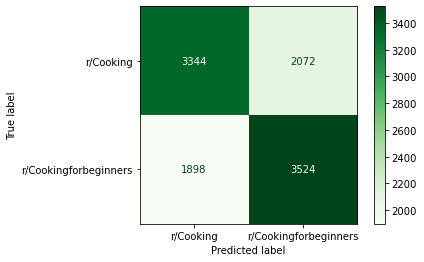

In [182]:
ConfusionMatrixDisplay.from_estimator(vc,X_test,y_test,cmap='Greens');

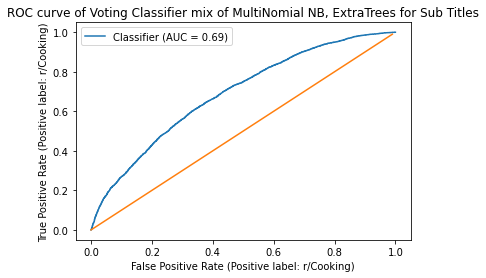

In [219]:
RocCurveDisplay.from_predictions(y_test,vc.predict_proba(X_test)[:,0],pos_label='r/Cooking')
sns.lineplot(x=np.arange(0,1,.01),y=np.arange(0,1,.01))
plt.title('ROC curve of Voting Classifier mix of MultiNomial NB, ExtraTrees for Sub Titles');

Just looking at it, it looks pretty smoothed over the top, as fitting from a classifier that is essentially a smoothing over of 3 methods

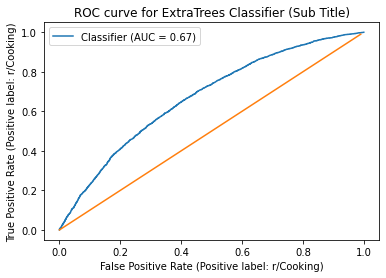

In [215]:
RocCurveDisplay.from_predictions(y_test,rsc6.best_estimator_.predict_proba(X_test)[:,0],pos_label='r/Cooking')
sns.lineplot(x=np.arange(0,1,.01),y=np.arange(0,1,.01))
plt.title('ROC curve for ExtraTrees Classifier (Sub Title)');

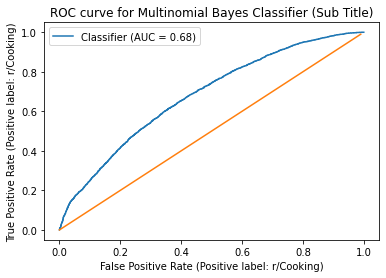

In [217]:
RocCurveDisplay.from_predictions(y_test,gs5.best_estimator_.predict_proba(X_test)[:,0],pos_label='r/Cooking')
sns.lineplot(x=np.arange(0,1,.01),y=np.arange(0,1,.01))
plt.title('ROC curve for Multinomial Bayes Classifier (Sub Title)');

Admittedly, they all look pretty similar

Just one last check, let's make a voting classifier where we don't have 2 classifiers on the same method. So, instead of normal MNB, let's use rsc4_1, the RFC

In [46]:
vc2 = VotingClassifier([
    ('rfcpl',rsc4_1),
    ('etc',rsc6.best_estimator_),
    ('mnblemma',pipersc5alt)
],voting='soft',n_jobs=-1)

In [47]:
start_time = time.time()
vc2.fit(X_train,y_train),
end_time = time.time()


vc2.score(X_train,y_train),vc2.score(X_test,y_test),end_time-start_time

(0.9814837598425197, 0.6337885218675032, 378.8243098258972)

After all that hubbub, it's .01 percent higher. But it is an improvement! (Probably non-existent on a different random-state, diffferent set of data)

One implication of this could be that in most cases, they're reaching very similar conclusions- in the ConfusionMatrixDisplay, none of them seemed particularly better at clearing one over the other class

But as an aside, please keep in mind that showing the same CMD overall metrics need not mean that they're covering the same ground. Example: if a population of birds has 60% blue wings and 60% hooked beaks, there need only be 20% birds that have both blue wings and hooked beaks.

In [52]:
rfcpreds = pd.DataFrame(rsc4_1.predict(X_test),columns=['randforestpred'])
efcpreds = pd.DataFrame(rsc6.best_estimator_.predict(X_test),columns=['extforestpred'])
mnbpreds = pd.DataFrame(pipersc5alt.predict(X_test),columns=['multinbpred'])

In [53]:
df_classes = pd.concat([pd.DataFrame(list(X_test),columns=['title']),
                        pd.DataFrame(list(y_test),columns=['ytrue']),
                        mnbpreds,rfcpreds,efcpreds],axis=1)

In [54]:
mnbtrue = df_classes['ytrue'] == df_classes['multinbpred']
rftrue = df_classes['ytrue'] == df_classes['randforestpred']
eftrue = df_classes['ytrue'] == df_classes['extforestpred']

In [55]:
df_classes[(~mnbtrue) & (~rftrue) & (~eftrue)].shape[0]/df_classes.shape[0]

0.20741834286768776

In [56]:
df_classes[(mnbtrue) & (rftrue) & (eftrue)].shape[0]/df_classes.shape[0]

0.44390108876176415

44.4% of the classes were correctly classified by all classifiers, and 20.7% incorrectly classified by all classifiers-of the remainder, 54.4% was correctly classified by the voting classifier ((vc2_true-all_correct)/(1-(all_correct+all_incorrect)))

In [57]:
df_classes[(~mnbtrue) & (rftrue) & (eftrue)].shape[0]/df_classes.shape[0]

0.08497877837239343

In [58]:
df_classes[(mnbtrue) & (~rftrue) & (eftrue)].shape[0]/df_classes.shape[0]

0.06292673925078428

In [59]:
df_classes[(mnbtrue) & (rftrue) & (~eftrue)].shape[0]/df_classes.shape[0]

0.04022882450636649

A hard voting classifier, just barely, underperforms the soft voting

In [60]:
vcpreds = pd.DataFrame(vc2.predict(X_test),columns=['votclasspred'])

In [61]:
df_classes = pd.concat([df_classes,vcpreds],axis=1)

In [62]:
vctrue = df_classes['ytrue'] == df_classes['votclasspred']

In [66]:
print(df_classes[~vctrue][['title','ytrue']].sample(10).to_string())

                                                      title                  ytrue
1956               What to do with a failed tiramisu cream?  r/Cookingforbeginners
6988                                              Tomatoes?  r/Cookingforbeginners
9256                       Substitute for oregano in chili?  r/Cookingforbeginners
9185   is lobster a creature originated from the west world  r/Cookingforbeginners
9128                 Does anyone know a cookbook like this?  r/Cookingforbeginners
10714   Will using vanilla greek yogurt mess up the recipe?  r/Cookingforbeginners
5952        What is your go to method for disposing grease?  r/Cookingforbeginners
5735           Can I steam frozen dinner rolls to make Bao?              r/Cooking
7718              Pasta Maker - How to choose the best one?  r/Cookingforbeginners
10787           Oats in soup? Yes, No, Maybe? I don't know.  r/Cookingforbeginners


In [105]:
print(df_classes[~vctrue][['title','ytrue']].sample(10).to_string())

                                                               title                  ytrue
4622                Been trying to perfect my Asian noodle soups....  r/Cookingforbeginners
2707                                                       A single?  r/Cookingforbeginners
8921   Tips for easy to make, store and cheap desserts for a buffet?              r/Cooking
7063     should apples be cooked before freezing or frozen uncooked?              r/Cooking
1221                             Ideas to pimp up a simple fish pie?              r/Cooking
2096                           Why is inside of my ground beef gray?  r/Cookingforbeginners
5119          What should I cook if I’m trying to cut back on carbs?  r/Cookingforbeginners
8264  Why did my warm cooking oil turn into jelly after deep frying?  r/Cookingforbeginners
4596      How to mix popcorn with spices without making it sluggish?              r/Cooking
2864                                   Beginner cook here, need help            

In [67]:
print(df_classes[~vctrue][['title','ytrue']].sample(10,random_state=29).to_string())

                                                               title                  ytrue
5561                                          How to turn it yummy ?              r/Cooking
3697                          How does one actually make beef gravy?              r/Cooking
7667                                               Lard? (Urban USA)  r/Cookingforbeginners
2846                  Do You Think Store-Bought Sauces Are Cheating?  r/Cookingforbeginners
2470                       Browning meatballs after cooking in oven?              r/Cooking
4806                               Onion texture and reheating help?  r/Cookingforbeginners
3804                               The first bite is with the eye...              r/Cooking
5000   Best easy, yet delicious meal to cook for a first first date?              r/Cooking
5699                                           Did I ruin my shrimp?              r/Cooking
10177                    Recipe: Old Beijing Zha Jiang Mian (老北京炸酱面)            

In [252]:
print(df_classes[~vctrue][['title','ytrue']].sample(10,random_state=108).to_string())

                                                                                                                                                                           title                  ytrue
2384                                                                                                                               Best time to add garlic when cooking chicken?              r/Cooking
3980                                                                          When do you add herbs to mash? Is it when you're boiling the potatoes or when you're mashing them?  r/Cookingforbeginners
8890                                                                                                                           Could anyone please help me convey these to gram?  r/Cookingforbeginners
9468                                                                                                                                            Send me your best salmon recipes  r/Cookingforbeginners


And now, some trues

In [253]:
print(df_classes[vctrue][['title','ytrue']].sample(10,random_state=64).to_string())

                                                                                                   title                  ytrue
615                          What recipes or foods can I make with dill, parsley, or basil (separately)?              r/Cooking
8637  Help me pick a Parmesan cheese for fettuccine Alfredo that I’m making for my girlfriend’s parents!              r/Cooking
6799                                                                                I'm A Little Puzzled  r/Cookingforbeginners
3211                             What one 'thing' did you change/do to take your dish to the next level?              r/Cooking
9297                                             How long do you find homemade mayo lasts in the fridge?              r/Cooking
6007                                  New Recipe Octopus Plus Cocacola Grill Food Recipe by Village Kids              r/Cooking
8963                                                                                         Suggestions

In [254]:
print(df_classes[vctrue][['title','ytrue']].sample(10,random_state=93).to_string())

                                                                                        title                  ytrue
4745                                                               Culinary Arts School Delhi  r/Cookingforbeginners
7884                                                    Where to get fresh fish in Manhattan?              r/Cooking
7388   What do I do with all of the strawberries from my garden? This is just today's harvest              r/Cooking
1333                                                 I've got tons of bell peppers - recipes?              r/Cooking
7703                                                What's the best way to cook a whole duck?              r/Cooking
9325                    Why do all my hard boiled eggs look like shit when I go to peel them?  r/Cookingforbeginners
10339                                                          Dumb question about gas stoves              r/Cooking
1556                                                Recipes with

In [255]:
print(df_classes[vctrue][['title','ytrue']].sample(10,random_state=321).to_string())

                                                                                        title                  ytrue
7395                               What to do with meatball ground beef other than meatballs?              r/Cooking
3499                                   What are your favorite meals for a small dinner party?              r/Cooking
4398                                                                pineapple stir fry quinoa  r/Cookingforbeginners
9740                      Korean Fried Chicken from the netflix KDrama "Crash Landing on You"              r/Cooking
10602                                          How can I cook in a healthier way for my kids?  r/Cookingforbeginners
5299                          Firming a custard pudding without corn starch , egg white okay?  r/Cookingforbeginners
5918   Question: How to triple a dinner recipe that normally uses an entire pan for one batch              r/Cooking
8937                                      Stay home &amp; cook! 

Where the NB classifier was better

In [264]:
df_classes[(~vctrue)&(mnbtrue)]['ytrue'].value_counts(normalize=True)

r/Cookingforbeginners    0.54731
r/Cooking                0.45269
Name: ytrue, dtype: float64

In [265]:
df_classes[(~vctrue)&(rftrue)]['ytrue'].value_counts(normalize=True)

r/Cooking                0.566631
r/Cookingforbeginners    0.433369
Name: ytrue, dtype: float64

In [267]:
df_classes[(~vctrue)&(eftrue)]['ytrue'].value_counts(normalize=True)

r/Cooking                0.529412
r/Cookingforbeginners    0.470588
Name: ytrue, dtype: float64

This is mild, but the multinomial bayes is better at CookingforBeginners, while the Forest methods are better at Cooking- this was somewhat showed earlier when the areas where RandForest/ExtraForest agreed and MNB disagreed where larger than any of the other conditions

In [268]:
print(df_classes[~vctrue&mnbtrue][['title','ytrue']].sample(10,random_state=321).to_string())

                                                                              title                  ytrue
10598                                          Do watch this INDIAN COOKING CHANNEL              r/Cooking
9008       Will my hand crushed tomatoes break down in my simmered bolognese sauce?  r/Cookingforbeginners
10676                         For Italian Pork Can I Use Lemon Instead of Balsamic?              r/Cooking
9702                                                           PORK EMBUTIDO RECIPE              r/Cooking
5380                                      I’m starting a cooking channel on YouTube              r/Cooking
9738   When to use chili oil or chili flakes in ramen? I can't tell the difference!              r/Cooking
5082                              How to properly use fan-forced oven fan settings?              r/Cooking
9383                                                                        Smoking              r/Cooking
9533                                 

In [269]:
print(df_classes[~vctrue&rftrue][['title','ytrue']].sample(10,random_state=321).to_string())

                                                                    title                  ytrue
6712                             What to do with pulled/shredded chicken?  r/Cookingforbeginners
6296                  How often do you cook for yourself in a given week?  r/Cookingforbeginners
3072               5 Health benefits that star anise can provide to women  r/Cookingforbeginners
354                                            Dried spice mix guide pdf?              r/Cooking
2321                               Substitutes for Toum and Shatta sauces  r/Cookingforbeginners
9352                                         Creaming egg yolks and sugar  r/Cookingforbeginners
1060                                    What to do with firm frozen tofu?  r/Cookingforbeginners
8239                 Học nghề đầu bếp chuyên nghiệp không cần thì đầu vào  r/Cookingforbeginners
670   How do y’all keep “heavy” or chunky stews from sticking to the pot?              r/Cooking
2574                  Black Be

In [272]:
print(df_classes[~vctrue&eftrue][['title','ytrue']].sample(10,random_state=1412).to_string())

                                                                                   title                  ytrue
5340                                                               Celebratory meal help  r/Cookingforbeginners
6452                When recipes ask for ‘bleu cheese’ what type of cheese do they mean?              r/Cooking
3500                                      Pudina Paratha Recipe in Hindi - पुदीना परांठा              r/Cooking
296                 What is information everyone who wants to learn to cook should know?              r/Cooking
7136                                            Made African stew but it needs something  r/Cookingforbeginners
8752                                                         Onions - colour v no colour              r/Cooking
7038                                         I'm in desperate need of new pots and pans.              r/Cooking
8649      I bought smoked trout instead of regular trout by accident. How do i use this?              r/

The following was used after consulting: https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features and https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

In [69]:
pipersc5alt[1][1].classes_ #in short, for the MultiNB, when looking at coefs, 'r/Cooking' is the first on the list

array(['r/Cooking', 'r/Cookingforbeginners'], dtype='<U21')

In [70]:
df_nb_ftimp = pd.DataFrame(pipersc5alt[1][1].feature_log_prob_.T,
             columns=pipersc5alt[1][1].classes_,index=pipersc5alt[1][0].get_feature_names_out())

In [71]:
df_nb_ftimp['probdiff'] = np.exp(df_nb_ftimp['r/Cooking']) - np.exp(df_nb_ftimp['r/Cookingforbeginners'])

In [72]:
df_nb_ftimp.sort_values(by='probdiff',ascending=False).head(10)

,r/Cooking,r/Cookingforbeginners,probdiff
what,-4.944735,-5.395215,0.002583
be,-4.568208,-4.780307,0.001983
what be,-5.910451,-6.549511,0.001280
your,-6.091630,-6.922070,0.001276
for,-4.843444,-4.986335,0.001049
you,-5.494250,-5.759904,0.000959
that,-6.033964,-6.481362,0.000864
have,-5.855782,-6.204294,0.000843
of,-5.328501,-5.518859,0.000841
do,-5.065605,-5.204284,0.000817


In [81]:
 df_nb_ftimp.sort_values(by='probdiff').head(10)

,r/Cooking,r/Cookingforbeginners,probdiff
how,-5.500551,-5.077072,-0.002154
easy,-7.325733,-5.972227,-0.001890
chicken,-5.934548,-5.417701,-0.001791
how to,-6.390024,-5.684038,-0.001722
make,-5.316335,-5.048049,-0.001511
and,-5.186359,-4.977660,-0.001298
to make,-6.442127,-5.911185,-0.001116
to,-4.538787,-4.441327,-0.001094
cook,-5.589748,-5.359377,-0.000968
recipe,-5.230727,-5.074587,-0.000904


In [91]:
nbcook = zip( df_nb_ftimp.sort_values(by='probdiff').head(10).index,
             df_nb_ftimp.sort_values(by='probdiff').head(10)['probdiff'])

In [92]:
x,y=zip(*nbcook)

In [101]:
nbcook2 = zip(df_nb_ftimp.sort_values(by='probdiff',ascending=False).head(10).index,
             df_nb_ftimp.sort_values(by='probdiff',ascending=False).head(10)['probdiff'])

In [102]:
x2,y2=zip(*nbcook2)

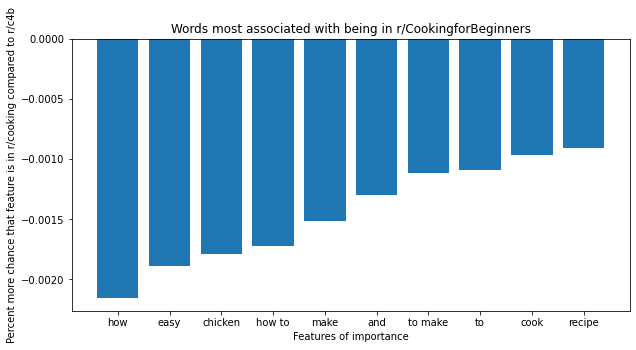

In [100]:
plt.figure(figsize=(10,5))
plt.bar(x,y)
plt.xlabel('Features of importance')
plt.ylabel('Percent more chance that feature is in r/cooking compared to r/c4b')
plt.title('Words most associated with being in r/CookingforBeginners');

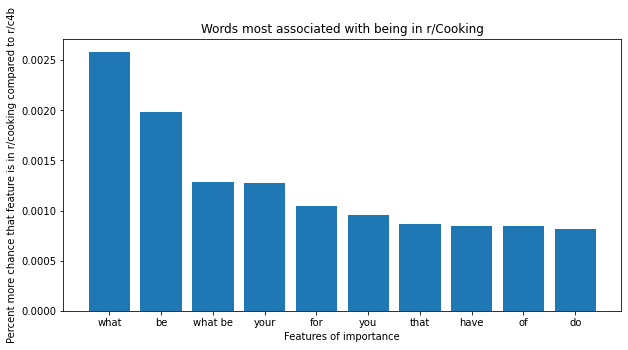

In [104]:
plt.figure(figsize=(10,5))
plt.bar(x2,y2)
plt.xlabel('Features of importance')
plt.ylabel('Percent more chance that feature is in r/cooking compared to r/c4b')
plt.title('Words most associated with being in r/Cooking');

So for cooking 'what,be,your,for you, that have, you, do' all are most predictive relative to cookingforbeginners
C4B is much more interpretable- 'how', 'easy', 'how to', 'to make', 'recipe' are all more predictive for C4B versus cooking

In [323]:
pd.DataFrame(rsc4_1.best_estimator_[1].feature_importances_,
             index=rsc4_1.best_estimator_[0].get_feature_names_out(),
             columns=['ft_imp']).sort_values(by='ft_imp',ascending=False).head(10)

,ft_imp
easy,0.009449
to,0.007308
for,0.007303
the,0.007236
chicken,0.006052
what,0.005875
in,0.005834
with,0.005680
of,0.005494
and,0.005127


In [324]:
pd.DataFrame(rsc6.best_estimator_[1].feature_importances_,
             index=rsc6.best_estimator_[0].get_feature_names_out(),
             columns=['ft_imp']).sort_values(by='ft_imp',ascending=False).head(10)

,ft_imp
easy,0.004718
chicken,0.002284
what,0.001959
for,0.001820
how,0.001774
to,0.001760
how to,0.001750
and,0.001671
recipe,0.001552
the,0.001481


Chicken! It keeps popping out as being predictive! Perhaps just as an all-around good starter food- and often prescribed as a useful starter food for bodybuilders- popular among the younger userbase of reddit.